# Stablecoin Health Monitor

### 1. _Fetching Stablecoin Data from CoinGecko (using Pro API Key) and saving it on a joblib file_

In [120]:
import os
import requests
import pandas as pd
from dotenv import load_dotenv

# Load your API key from .env file
load_dotenv()
COINGECKO_PRO_API_KEY = os.getenv("COINGECKO_PRO_API_KEY")

# Set up API endpoint and parameters
url = "https://pro-api.coingecko.com/api/v3/coins/markets"
params = {
    "vs_currency": "usd",
    "category": "stablecoins",
    "order": "market_cap_desc",
    "per_page": 50,
    "page": 1,
    "sparkline": False
}
headers = {
    "x-cg-pro-api-key": COINGECKO_PRO_API_KEY
}

# Make the request
response = requests.get(url, params=params, headers=headers)
data = response.json()

# Convert to DataFrame
df = pd.DataFrame(data)
df.head()

,id,symbol,name,image,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,...,total_supply,max_supply,ath,ath_change_percentage,ath_date,atl,atl_change_percentage,atl_date,roi,last_updated
0,tether,usdt,Tether,https://coin-images.coingecko.com/coins/images...,1.000000,168025023311,3,168025023311,7.591407e+10,1.00000,...,1.680075e+11,NaN,1.320,-24.41286,2018-07-24T00:00:00.000Z,0.572521,74.68178,2015-03-02T00:00:00.000Z,None,2025-09-01T13:54:24.311Z
1,usd-coin,usdc,USDC,https://coin-images.coingecko.com/coins/images...,0.999812,71586954052,7,71581911569,8.392671e+09,0.99993,...,7.159527e+10,NaN,1.170,-14.74283,2019-05-08T00:40:28.300Z,0.877647,13.92011,2023-03-11T08:02:13.981Z,None,2025-09-01T13:54:26.514Z
2,ethena-usde,usde,Ethena USDe,https://coin-images.coingecko.com/coins/images...,1.001000,12408026344,16,12408026344,2.172225e+08,1.00100,...,1.240057e+10,NaN,1.032,-3.05841,2023-12-20T15:38:34.596Z,0.929486,7.64194,2024-10-04T07:57:15.809Z,None,2025-09-01T13:54:23.944Z
3,usds,usds,USDS,https://coin-images.coingecko.com/coins/images...,0.999682,7997126166,30,8011015411,4.357874e+06,1.00000,...,8.011786e+09,NaN,1.057,-5.43797,2024-10-29T05:40:51.197Z,0.948265,5.43731,2024-10-03T13:19:28.826Z,None,2025-09-01T13:54:26.029Z
4,dai,dai,Dai,https://coin-images.coingecko.com/coins/images...,0.999878,4582195396,41,4582195396,1.224708e+08,1.00000,...,4.582761e+09,NaN,1.220,-17.97068,2020-03-13T03:02:50.373Z,0.881960,13.37028,2023-03-11T07:50:50.514Z,None,2025-09-01T13:54:22.321Z


In [121]:
df['symbol'].value_counts().sum()
df.shape

(50, 26)

In [122]:
import joblib

# Save raw data (list of dicts) to a joblib file
joblib.dump(data, "../data/stablecoins_raw.joblib")

['../data/stablecoins_raw.joblib']

### 2. _Fetching global market data to get stablecoin dominance_

In [123]:
# Usdt and usdc alone

market_caps = global_data['data']['market_cap_percentage']
stablecoin_dominance = market_caps.get('usdt', 0) + market_caps.get('usdc', 0)
print("Total Stablecoin Dominance (%) of USDT and USDC alone:", stablecoin_dominance, "%")

Total Stablecoin Dominance (%) of USDT and USDC alone: 6.238504966984056 %


In [124]:
# Calculate individual dominance for all major stablecoins using /coins/markets data
# Get total market cap from global data
total_market_cap = global_data['data']['total_market_cap']['usd']

# List of major stablecoins (update as needed)
stablecoins = ['usdt', 'usdc', 'dai', 'busd', 'tusd', 'gusd', 'frax', 'eurt', 'alusd']

# Use the original CoinGecko markets DataFrame for market cap calculations

df_markets = pd.DataFrame(data)

# Calculate dominance for each stablecoin
dominance_dict = {}
for coin in stablecoins:
    coin_data = df_markets[df_markets['symbol'] == coin]
    if not coin_data.empty and 'market_cap' in coin_data.columns:
        market_cap = coin_data.iloc[0]['market_cap']
        dominance = (market_cap / total_market_cap) * 100
        dominance_dict[coin] = dominance
    else:
        dominance_dict[coin] = 0

# Filter out stablecoins with zero dominance
filtered_dominance = {coin: dom for coin, dom in dominance_dict.items() if dom > 0}

print("Major Stablecoins with Non-Zero Dominance (%):", filtered_dominance)
print("Total Stablecoin Dominance (%):", sum(filtered_dominance.values()))

Major Stablecoins with Non-Zero Dominance (%): {'usdt': np.float64(4.378290452763172), 'usdc': np.float64(1.865367855882621), 'dai': np.float64(0.11939996769331657), 'busd': np.float64(0.008137443124427265), 'tusd': np.float64(0.01286256432339631), 'frax': np.float64(0.00771828502829014)}
Total Stablecoin Dominance (%): 6.391776568815223


In [125]:
# Put filtered dominance results in a DataFrame
import pandas as pd

filtered_dominance = {coin: dom for coin, dom in dominance_dict.items() if dom > 0}
dominance_df = pd.DataFrame(list(filtered_dominance.items()), columns=['Stablecoin', 'Dominance (%)'])
dominance_df

,Stablecoin,Dominance (%)
0,usdt,4.378290
1,usdc,1.865368
2,dai,0.119400
3,busd,0.008137
4,tusd,0.012863
5,frax,0.007718


In [126]:
import plotly.express as px

# Interactive bar chart
fig = px.bar(
    dominance_df,
    x="Stablecoin",
    y="Dominance (%)",
    text="Dominance (%)",
    title="Stablecoin Dominance (%)",
    labels={"Stablecoin": "Stablecoin", "Dominance (%)": "Dominance (%)"},
    template="plotly_white"
)

# Add text on top of bars
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')

# Adjust layout
fig.update_layout(
    xaxis_title="Stablecoin",
    yaxis_title="Dominance (%)",
    height=600,
    width=800
)

fig.show()


In [127]:
fig = px.pie(
    dominance_df,
    names="Stablecoin",
    values="Dominance (%)",
    title="Stablecoin Dominance (%)",
    hole=0.3,  # makes it a donut chart
    template="plotly_white"
)

fig.update_traces(textinfo="label+percent", hovertemplate="Stablecoin: %{label}<br>Dominance: %{value:.2f}%")

fig.show()



In [128]:
print("Total Stablecoin Dominance (%) of these 6 stablecoins:", sum(filtered_dominance.values()), "%")

Total Stablecoin Dominance (%) of these 6 stablecoins: 6.391776568815223 %


### 3. _Analyzing Peg Deviation_
This calculates how much each stablecoin’s price deviates from $1 (the peg).

a. Current peg deviation

In [129]:
# Analyze Peg Deviation for Major Stablecoins (6 of them)

# Use filtered_dominance keys to focus on major stablecoins with non-zero dominance
peg_deviation = {}
for coin in filtered_dominance.keys():
    coin_data = df[df['symbol'] == coin]
    if not coin_data.empty:
        price = coin_data.iloc[0]['current_price']
        deviation = price - 1  # Difference from $1
        peg_deviation[coin] = deviation

# Put results in a DataFrame
peg_df = pd.DataFrame(list(peg_deviation.items()), columns=['Stablecoin', 'Peg Deviation ($)'])
peg_df

,Stablecoin,Peg Deviation ($)
0,usdt,0.000000
1,usdc,-0.000188
2,dai,-0.000122
3,busd,-0.000349
4,tusd,-0.001749
5,frax,-0.002446


In [130]:
peg_df['Peg Deviation (%)'] = peg_df['Peg Deviation ($)'] * 100
peg_df

,Stablecoin,Peg Deviation ($),Peg Deviation (%)
0,usdt,0.000000,0.0000
1,usdc,-0.000188,-0.0188
2,dai,-0.000122,-0.0122
3,busd,-0.000349,-0.0349
4,tusd,-0.001749,-0.1749
5,frax,-0.002446,-0.2446


b. Peg deviation overtime for these 6 major stablecoins in the last 365 days

In [131]:
import joblib

# CoinGecko IDs for the 6 major stablecoins in my case study
coingecko_ids = {
    'usdt': 'tether',
    'usdc': 'usd-coin',
    'dai': 'dai',
    'busd': 'binance-usd',
    'tusd': 'true-usd',
    'frax': 'frax'
}

# Function to fetch historical prices and calculate peg deviation
def fetch_historical_deviation(coin_id, days=365):
    url = f"https://pro-api.coingecko.com/api/v3/coins/{coin_id}/market_chart"
    params = {
        "vs_currency": "usd",
        "days": days
    }
    headers = {"x-cg-pro-api-key": COINGECKO_PRO_API_KEY}
    response = requests.get(url, params=params, headers=headers)
    data = response.json()
    prices = data.get("prices", [])
    df = pd.DataFrame(prices, columns=["timestamp", "price"])
    df["date"] = pd.to_datetime(df["timestamp"], unit="ms")
    df["peg_deviation (USD)"] = df["price"] - 1
    df["peg_deviation (%)"] = (df["price"] - 1) * 100
    return df

# Fetch historical peg deviation for each stablecoin (last 365 days)
historical_deviation_data = {}
for symbol, coin_id in coingecko_ids.items():
    df_hist = fetch_historical_deviation(coin_id, days=365)
    historical_deviation_data[symbol] = df_hist

# Save the historical deviation data to a joblib file
joblib.dump(historical_deviation_data, "../data/stablecoins_historical_deviation.joblib")


['../data/stablecoins_historical_deviation.joblib']

In [132]:
historical_deviation_data = joblib.load("../data/stablecoins_historical_deviation.joblib")

# Concatenate all DataFrames, adding a column for the stablecoin symbol
df = pd.concat(
	[df_hist.assign(symbol=symbol) for symbol, df_hist in historical_deviation_data.items() if not df_hist.empty],
	ignore_index=True
)
df.shape

(2196, 6)

In [133]:
df.nunique()

timestamp               371
price                  2196
date                    371
peg_deviation (USD)    2196
peg_deviation (%)      2196
symbol                    6
dtype: int64

In [134]:
df['symbol'].value_counts()

symbol
usdt    366
usdc    366
dai     366
busd    366
tusd    366
frax    366
Name: count, dtype: int64

In [135]:
for symbol, df_hist in historical_deviation_data.items():
    print(symbol, df_hist.shape)

usdt (366, 5)
usdc (366, 5)
dai (366, 5)
busd (366, 5)
tusd (366, 5)
frax (366, 5)


In [136]:
df.head()

,timestamp,price,date,peg_deviation (USD),peg_deviation (%),symbol
0,1725235200000,1.000525,2024-09-02,0.000525,0.052496,usdt
1,1725321600000,0.999975,2024-09-03,-0.000025,-0.002535,usdt
2,1725408000000,0.998101,2024-09-04,-0.001899,-0.189855,usdt
3,1725494400000,1.000062,2024-09-05,0.000062,0.006182,usdt
4,1725580800000,0.999541,2024-09-06,-0.000459,-0.045869,usdt


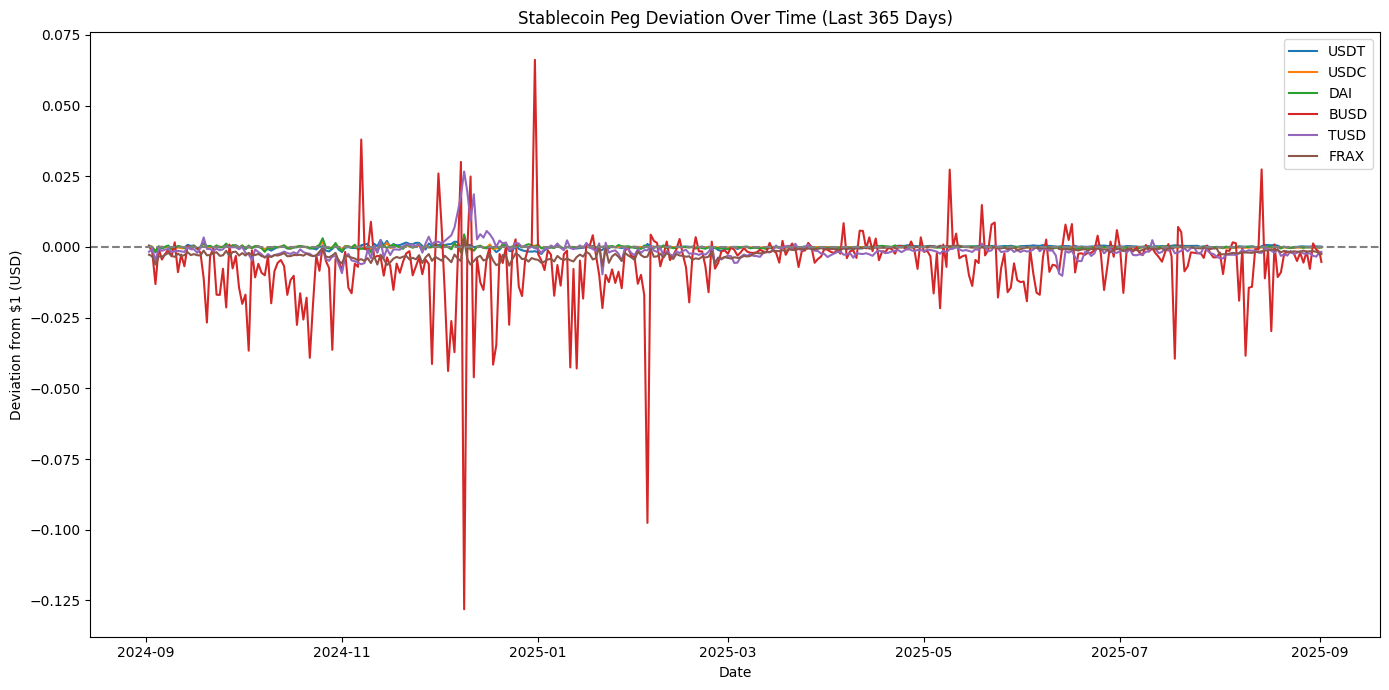

In [137]:
# using matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
for symbol, df_hist in historical_deviation_data.items():
    if not df_hist.empty:
        plt.plot(df_hist["date"], df_hist["peg_deviation (USD)"], label=symbol.upper())

plt.axhline(0, color="gray", linestyle="--")
plt.title("Stablecoin Peg Deviation Over Time (Last 365 Days)")
plt.xlabel("Date")
plt.ylabel("Deviation from $1 (USD)")
plt.legend()
plt.tight_layout()
plt.show()

In [138]:
# using plotly for interactive visualization and log scale for y-axis

import plotly.graph_objs as go
import plotly.offline as pyoff

# Create interactive chart with log scale for y-axis
fig = go.Figure()

for symbol, df_hist in historical_deviation_data.items():
    if not df_hist.empty:
        fig.add_trace(go.Scatter(
            x=df_hist["date"],
            y=df_hist["peg_deviation (USD)"].abs() + 1e-8,  # add small value to avoid log(0)
            mode='lines',
            name=symbol.upper()
        ))

fig.update_layout(
    title="Stablecoin Peg Deviation Over Time (Last 365 Days) [Log Scale]",
    xaxis_title="Date",
    yaxis_title="Deviation from $1 (log scale, abs)",
    yaxis_type="log",
    legend_title="Stablecoin",
    template="plotly_white",
    height=600,
    width=1000
)

pyoff.iplot(fig)